# «ГлавРосГосНефть»

### Описание проекта
Вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.


Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

### Условия задачи:
 - Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
 - При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
 - Бюджет на разработку скважин в регионе — 10 млрд рублей.
 - Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
 - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

*Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.*

### Описание данных
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

### План работы
1. [**Загрузка и подготовка данных**](#load)
    1. [Исследование признаков](#eda)
2. [**Обучение и проверка модели для каждого региона:**](#fit)
    1. [Разбивка данных на обучающую и валидационную выборки в соотношении 75:25.](#split)
    2. [Обучение модели и предсказания на валидационной выборке.](#predict)
    3. [Расчет среднего запаса предсказанного сырья и RMSE модели.](#metrics)
    4. [Анализ результатов.](#analysis)
3. [**Подготовка к расчёту прибыли:**](#calc)
    1. [Создание переменных с ключевыми значениями для расчётов.](#const)
    2. [Расчёт достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение полученного объёма сырья со средним запасом в каждом регионе.](#capacity)
4. [**Создание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели**:](#revenue)
    1. [Выбор скважин с максимальными значениями предсказаний. Количество скважин зависит от бюджета компании и стоимости разработки одной скважины.](#wells)
    2. [Расчёт прибыли для полученного объёма сырья.](#volume)
5. [**Расчет рисков и прибыли для каждого региона:**](#risk)
    1. [Использование техники Bootstrap с 1000 выборок, чтобы найти распределение прибыли.](#bootstrap)
    2. [Cредняя прибыль, 95%-й доверительный интервал и риск убытков. (Убыток — это отрицательная прибыль).](#mean)
6. [**Общий вывод: выбор региона для разработки скважин.**](#output)

---
<a id='load'></a>
## 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
g0 = pd.read_csv('/datasets/geo_data_0.csv')
g1 = pd.read_csv('/datasets/geo_data_1.csv')
g2 = pd.read_csv('/datasets/geo_data_2.csv')
dfs = {'geo_data_0':g0, 'geo_data_1':g1, 'geo_data_2':g2}

In [3]:
def information(dataframes):
    for i in dataframes:
        display(dataframes[i].head())
        print()
        dataframes[i].info()
        print()
        display(dataframes[i].isna().sum().to_frame(name=f'missed values {i}'))
        print()
        print(f'Количество дубликатов в столбцах для датасета {i}:', dataframes[i].duplicated().sum())

In [4]:
information(dfs)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,missed values geo_data_0
id,0
f0,0
f1,0
f2,0
product,0



Количество дубликатов в столбцах для датасета geo_data_0: 0


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,missed values geo_data_1
id,0
f0,0
f1,0
f2,0
product,0



Количество дубликатов в столбцах для датасета geo_data_1: 0


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,missed values geo_data_2
id,0
f0,0
f1,0
f2,0
product,0



Количество дубликатов в столбцах для датасета geo_data_2: 0


Перед нами датасеты трех регионов с информацией о месторождениях нефти. В данных нет пропусков и полных дубликатов, в каждом датасете по 100000 записей. Изучим информацию об идентификаторах скважин, проверим их на уникальность:

In [5]:
num_uniq = [dfs[i]['id'].nunique() for i in dfs]
print('Число уникальный идентификаторов месторождений для каждого датасета g0-g2:', end=' ')
print(*num_uniq, sep=', ')
print('Суммарное число уникальных идентификаторов месторождений:', sum(num_uniq))
print('Суммарное число уникальных идентификаторов месторождений после склейки трех датасетов:', 
      pd.concat([*[dfs[i]['id'] for i in dfs]]).nunique())

Число уникальный идентификаторов месторождений для каждого датасета g0-g2: 99990, 99996, 99996
Суммарное число уникальных идентификаторов месторождений: 299982
Суммарное число уникальных идентификаторов месторождений после склейки трех датасетов: 299951


Судя по всему в данных встречаются дублирующие идентификаторы скважин, но в очень небольшом количестве, суммарно в трех датасетах 18 записей. Так как нет возможности определить, действительно ли это дубликат или ошибка в названии, оставим данные в прежнем виде, поскольку процент записей настолько небольшой, что едва ли это повлияет на дальнейшие выводы.

---
<a id='eda'></a>
Подробнее изучим признаки:

In [6]:
for i in dfs.values():
    display(i.describe().round(2))

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


Столбцы с признаками `f0`,`f1`,`f2` заранее приведены к масштабу, судя по описательным статистикам. Максимальные значения столбцов `product` различаются не более чем на 32% с 3-им квартилем, что скорее говорит об отсутствии аномальных значений. 

Посмотрим, как распределены данные в этих столбцах и построим диаграммы размаха для исследования выбросов:

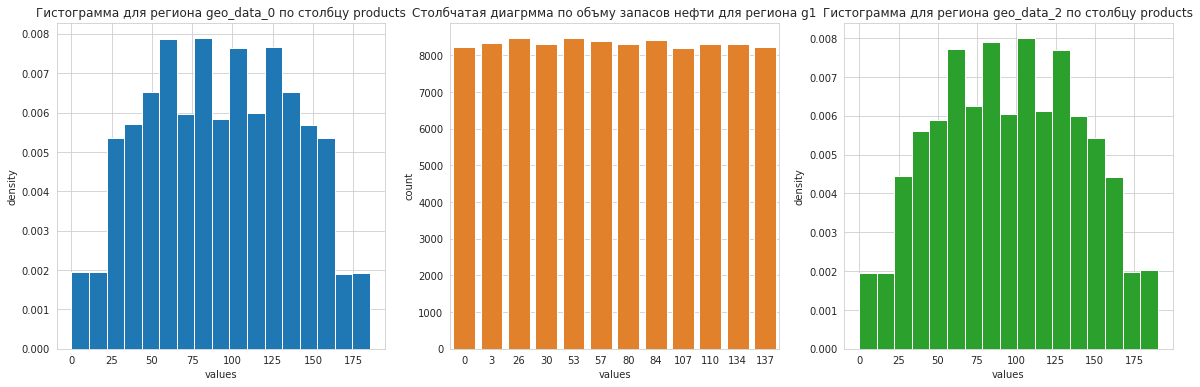

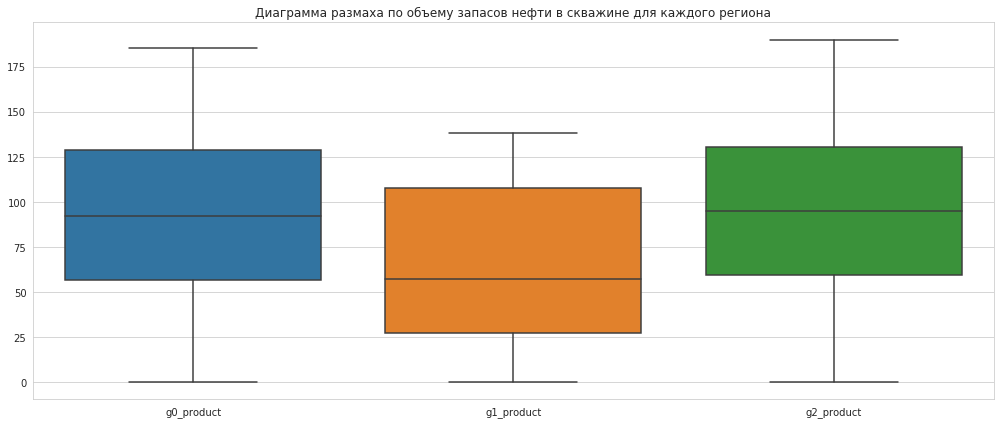

In [7]:
plt.subplots(figsize=(20, 6))
for k,i in enumerate(dfs):
    if i == 'geo_data_1':
        plt.subplot(1,3,k+1)
        sns.countplot(g1['product'].astype(int), palette=['C1'])
        plt.title('Столбчатая диагрмма по объму запасов нефти для региона g1')
        plt.xlabel('values')
    else:
        bins = int(1 + np.log2(len(dfs[i])))
        plt.subplot(1,3,k+1)
        plt.hist(dfs[i]['product'], bins=bins, color='C'+str(k), density=True)
        plt.xlabel('values')
        plt.ylabel('density')
        plt.title(f'Гистограмма для региона {i} по столбцу products')
plt.show()
prods = g0['product'].to_frame(name='g0_product').assign(g1_product = g1['product'], g2_product = g2['product'])
plt.figure(figsize=(14,6))
sns.boxplot(data=prods)
plt.title(('Диаграмма размаха по объему запасов нефти в скважине для каждого региона'))
plt.tight_layout()
plt.show()

Данные в регионах geo_0 и geo_2 визуально имееют форму нормального распределения, в geo_1 данные распределены равномерно. Выбросы в столбцах отсутствуют. 

Проверим, соответствуют ли они норнмальному распределению при помощи теста Шапиро-Уилка:

In [8]:
a = 0.05
for i in dfs:
    pvalue = st.shapiro(dfs[i]['product'].sample(5000))[1]
    if pvalue > a:
        print(f'Для столбца product региона {i} принимаем нулевую гипотезу, распределение соответсвует нормальному')
    else:
        print(f'Для столбца product региона {i} принимаем альтернативную гипотезу, распределение не нормально')

Для столбца product региона geo_data_0 принимаем альтернативную гипотезу, распределение не нормально
Для столбца product региона geo_data_1 принимаем альтернативную гипотезу, распределение не нормально
Для столбца product региона geo_data_2 принимаем альтернативную гипотезу, распределение не нормально


Построим графики взаимной корреляции признаков для трех датасетов:

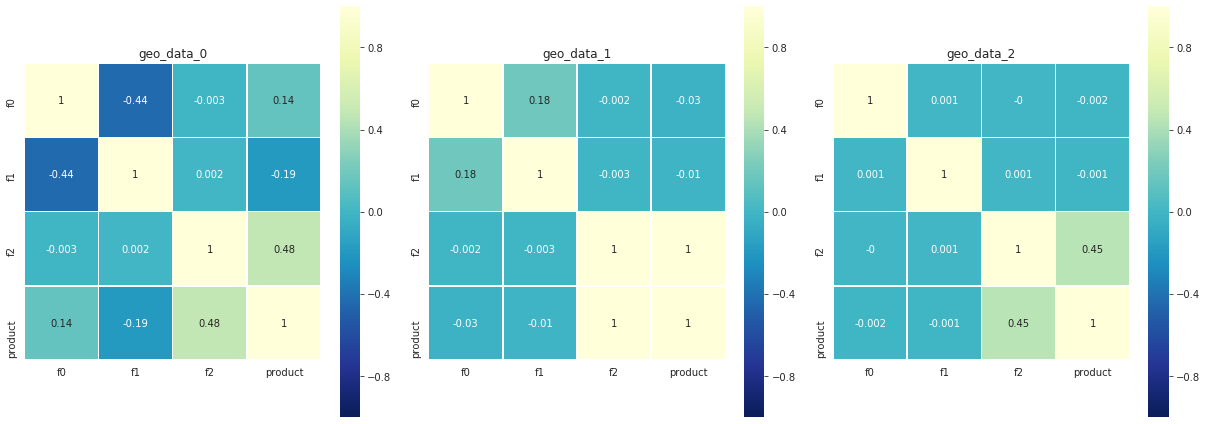

In [9]:
plt.subplots(figsize=(17, 6))
for k,i in enumerate(dfs):
    plt.subplot(1,3,k+1)
    ax = sns.heatmap(dfs[i].corr().round(3), annot=True, square=True, linewidths=.5, center=0, vmin=-1, vmax=1,
                    cmap="YlGnBu_r")
    ax.set_ylim(4, 0)
    plt.title(i)
#print(ax.get_ylim())
plt.tight_layout()
plt.show()

Интересно то, что в датасете geo_1, данные столбца f2 сильно скоррелированы с целевой переменной, в остальных столбцах нет выраженной корреляции между признаками.

### Вывод:

Всего в каждом датасете по 100000 записей 3 столбца с признаками и целевая переменная с объемом нефти в скважине. Данные с признаками масштабированы, данные целевой переменной не распределены нормально, аномалий, полных дубликатов и пропусков в данных нет. В датасете geo_1, данные столбца f2 сильно скоррелированы с целевой переменной, в остальных столбцах нет выраженной корреляции между признаками.

---
<a id='fit'></a>
## 2. Обучение и проверка модели

Выделим признаки и целевую переменную:

In [10]:
g0_features = g0.drop(['id', 'product'], axis=1)
g0_target = g0['product']

g1_features = g1.drop(['id', 'product'], axis=1)
g1_target = g1['product']

g2_features = g2.drop(['id', 'product'], axis=1)
g2_target = g2['product']

<a id='split'></a>
Разобьем выборки на обучающую и валидационную:

In [11]:
def splitter(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=42)
    return features_train, features_valid, target_train, target_valid

In [12]:
g0_features_train, g0_features_valid, g0_target_train, g0_target_valid = splitter(g0_features, g0_target)
g1_features_train, g1_features_valid, g1_target_train, g1_target_valid = splitter(g1_features, g1_target)
g2_features_train, g2_features_valid, g2_target_train, g2_target_valid = splitter(g2_features, g2_target)

<a id='predict'></a>
Создадим модели линейной регрессии, обучим их на тренировочных выборках и предскажем значения для валидационных:

In [13]:
def linear_func(features_train, target_train, features_valid):
    linear_model = LinearRegression()
    linear_model.fit(features_train, target_train)
    return linear_model.predict(features_valid)

In [14]:
g0_preds = linear_func(g0_features_train, g0_target_train, g0_features_valid)
g1_preds = linear_func(g1_features_train, g1_target_train, g1_features_valid)
g2_preds = linear_func(g2_features_train, g2_target_train, g2_features_valid)

<a id='metrics'></a>
Изучим результаты предсказаний (средний предсказанный запас нефти, метрики RMSE, R2, MAE):

In [15]:
def metrics(target, predicted):
    rmse = round(mean_squared_error(target, predicted)**.5,2)
    rmse_random = round(mean_squared_error(target, pd.Series(target.mean(), range(len(target))))**.5,2)
    r2 = round(r2_score(target, predicted),4)
    mae = round(mean_absolute_error(target, predicted),2)
    real_mean = round(np.mean(target),2)
    predicted_mean = round(np.mean(predicted),2)
    return rmse, rmse_random, r2, mae, real_mean, predicted_mean

def df_builder(values_list, columns_list):
    index=['geo_0', 'geo_1', 'geo_2']
    dataframe = pd.DataFrame(data=values_list, columns=columns_list, index=index)
    return dataframe

In [16]:
metrics_data = [*[metrics(g0_target_valid, g0_preds)],
                *[metrics(g1_target_valid, g1_preds)],
                *[metrics(g2_target_valid, g2_preds)]]
metrics_columns = columns=['rmse', 'rmse_constant', 'r2','mae', 'real_mean', 'predicted_mean']

In [17]:
display(df_builder(metrics_data, metrics_columns))

,rmse,rmse_constant,r2,mae,real_mean,predicted_mean
geo_0,37.76,44.28,0.2728,31.05,92.33,92.40
geo_1,0.89,45.94,0.9996,0.72,68.73,68.71
geo_2,40.15,44.78,0.1963,32.90,95.15,94.77


Самые точные предсказания получились для первого региона. Коэффициент детерминации R2 равен 0.9996, корень средний ошибки составляет всего 0.89 тыс. баррелей. Средние предсказанные и реальные значения практически полностью совпадают. Наименее точные предсказания получились для третьего региона. RMSE 40.15, что едва ли ниже RMSE предсказаний константной модели - 44.78, коэффициент детерминации составляет 0.1963. Для первого региона R2 = 0.27, RMSE = 37.76.

<a id='analysis'></a>
### Вывод

На этом этапе разбили выборки на тренировочную и валидационную для каждого региона, обучили модели линейной регресии и получили следующие результаты метрик по предсказанным значениям:

`Geo_0`:
- RMSE: 37.76
- MAE: 31.05
- R2: 0.2728
- Predicted Mean: 92.40

`Geo_1`:
- RMSE: 0.89
- MAE: 0.72
- R2: 0.9996
- Predicted Mean: 68.71

`Geo_2`:
- RMSE: 40.15
- MAE: 32.90
- R2: 0.1963
- Predicted Mean: 94.77

Самые точные предсказания получились для первого региона, при этом средний объём сырья в скважине в первом регионе самый низкий - 68 тыс. баррелей.

---
<a id='calc'></a>
## 3. Подготовка к расчёту прибыли

<a id='const'></a>
Создадим переменные с ключевыми значениями для расчетов:

In [18]:
BUDGET = 10e9
REVENUE = 45e4
BEST_LEN = 200

<a id='capacity'></a>
Рассчитаем достаточный объем сырья для безубыточной разработки новой скважины:

In [19]:
capacity = BUDGET / REVENUE / BEST_LEN
print(f'Достаточный объём сырья составляет: {round(capacity, 2)}')

Достаточный объём сырья составляет: 111.11


Сравним полученный объём сырья со средним запасом в каждом регионе:

In [20]:
def volume(target, predictions):
    df = target.to_frame(name='true_values')
    df['predicted_values'] = predictions
    pred_mean = int(df['predicted_values'].sort_values(ascending=False).iloc[:200].mean())
    real_mean = int(df.sort_values(by='predicted_values', ascending=False).iloc[:200]['true_values'].mean())
    return real_mean, pred_mean

In [21]:
vol_data = [*[volume(g0_target_valid,g0_preds)],
            *[volume(g1_target_valid,g1_preds)],
            *[volume(g2_target_valid,g2_preds)]]
cols_vol = ['real_mean', 'predicted_mean']

In [22]:
display(df_builder(vol_data,cols_vol))

,real_mean,predicted_mean
geo_0,148,154
geo_1,137,138
geo_2,139,148


### Вывод:
Поскольку средний объем сырья берется из двухста точек, то отсортировав предсказанные значения по убыванию можно посчитать среднее от первых 200 записей и сопоставить их со средними реального объема скважин. Таким образом, средний объём сырья будет достаточным для каждого региона, при выборе лучших 200 скважин. При этом, как было отмечено ранее, наиболее точные предсказания выполнены для первого региона, разница составляет 1 тыс. баррелей, для остальных регионов значения несколько завышены.

---
<a id='revenue'></a>
## 4. Расчёт прибыли
<a id='wells'></a>
Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели, выберем скважины с максимальными значениями предсказаний.

In [23]:
def predicted_revenue(predictions):
    return int(pd.Series(predictions).sort_values(ascending=False).head(200).sum() * REVENUE - BUDGET)
def real_revenue(df):
    return int(df.sort_values(by='predicted_values', ascending=False).iloc[:200]['true_values'].sum() 
               * REVENUE - BUDGET)
def calculate_revenue(target, predictions):
    df = target.to_frame(name='true_values')
    df['predicted_values'] = predictions
    error = 1-round(real_revenue(df)/predicted_revenue(predictions),2)
    return real_revenue(df), predicted_revenue(predictions), error

In [24]:
revenue_data = [*[calculate_revenue(g0_target_valid, g0_preds)], 
                *[calculate_revenue(g1_target_valid, g1_preds)],
                *[calculate_revenue(g2_target_valid, g2_preds)]]
columns_revenue = ['real_revenue', 'predicted_revenue','error_ratio']

In [25]:
display(df_builder(revenue_data, columns_revenue))

,real_revenue,predicted_revenue,error_ratio
geo_0,3359141114,3896658479,0.14
geo_1,2415086696,2486938114,0.03
geo_2,2598571759,3377981513,0.23


<a id='volume'></a>
### Вывод

Таким образом реальная прибыль с каждой региона по предсказанным данным составит:

- `Geo_0`: 3 359 141 114	
- `Geo_1`: 2 415 086 696
- `Geo_2`: 2 598 571 759

Самая большая реальная прибыль получается в регионе `Geo_0`, при этом она на 14% ниже относительно предсказанной прибыли. Реальная прибыль в регионе `Geo_2`, ниже на 23% по сравнению с предсказанными данными. Самая низкая прибыль в регионе `Geo_1`, однако предсказания согласуются лучше всего с реальными данными при незначительных отклонениях.

---
<a id='risk'></a>
## 5. Рассчет средней прибыли и рисков для каждого региона:

<a id='bootstrap'></a>
Используем технику Bootstrap, чтобы найти распределение прибыли. Для этого из 1000 выборок будем извлекать по 500 случайных записей, брать 200 лучших и рассчитывать на них прибыль. После того, как получим все значения прибыли, рассчитаем 95% доверительный интервал и среднюю прибыль:

In [26]:
def bootstrap(target, predictions):
    state = np.random.RandomState(42)
    df = target.to_frame(name='true_values')
    df['predicted_values'] = predictions
    vals = []
    for i in range(1000):
        subsample = df.sample(500, replace=True, random_state=state)
        vals.append(real_revenue(subsample))
    lower = int(np.quantile(vals, 0.025))
    upper = int(np.quantile(vals, 0.975))
    means = int(np.mean(vals))
    prob_risk = len(list(filter(lambda x: x<0, vals))) / len(vals)
    return lower, upper, means, prob_risk

In [27]:
bootstrap_data = [*[bootstrap(g0_target_valid,g0_preds)],
                  *[bootstrap(g1_target_valid,g1_preds)], 
                  *[bootstrap(g2_target_valid,g2_preds)]]
bootstrap_cols = ['lower_2.5%','upper_97.5%','mean','proba_risk']

In [28]:
display(df_builder(bootstrap_data, bootstrap_cols))

,lower_2.5%,upper_97.5%,mean,proba_risk
geo_0,-110467894,897460327,399575477,0.060
geo_1,61684479,845340176,452048890,0.015
geo_2,-144766726,888390402,375009902,0.080


<a id='mean'></a>
### Вывод

Таким образом, 95% прибыли по предсказанным значениям будет находиться в интервале:

- `Geo_0`: -110 млн - 897 млн, средняя прибыль 399 млн
- `Geo_1`: 61 млн - 845 млн, срденяя прибыль 452 млн
- `Geo_2`: -144 млн 888 млн, средняя прибыль 375 млн

При этом, риск убытков составит:
- `Geo_0`: 6%
- `Geo_1`: 1.5%
- `Geo_2`: 8%

<a id='output'></a>
## Общий вывод

Были изучены датасеты с 3-мя регионами с данными о месторождениях нефти, были построены модели линейной регрессии, выполнено их обучение и сделаны предсказания на валидационной выборке. 

Самые точные предсказания модели линейной регресии получились для первого региона, метрики составили:

`Geo_1`:
- RMSE: 0.89
- R2: 0.9996

Для моделей регионов  `Geo_0` и `Geo_2` метрики RMSE составили 37.76 и 40.15, а R2 0.2728 и 0.1963, что в целом говорит о не очень выской точности предсказаний. 

Был рассчитан достаточный объем сырья для безубыточной разработки новой скважины, он составляет 111.1 тыс. баррелей. 
Средний объем реальных и предсказанных значений по всей валидационной выборке составляет:
`Geo_0`: 92 тыс. баррелей, `Geo_1`: 68 тыс. баррелей `Geo_1`: 95 тыс. баррелей, при этом средний реальный объем для 200 лучших скважин по предсказанным данным составляет 148, 137 и 139 тыс. баррелей. Стоит отметить, что для регионов 0 и 2 средние предсказания немного завышены из-за точности модели.

Была рассчитана максимальная реальная прибыль с каждого региона по предсказанным данным из 200 лучших скважин, она составляет:

- `Geo_0`: 3 359 141 114	
- `Geo_1`: 2 415 086 696
- `Geo_2`: 2 598 571 759

При этом предсказания для нулевого и второго региона выше на 14%-23%, для первого региона погрешность составляет 3%.

При помощи техники Bootstrap была рассчитана прибыль для каждого региона в 95% доверительном интервале и средняя прибыль с риском убытков:

- `Geo_0`: -110 млн - 897 млн, средняя прибыль 399 млн, риск убытков 6%
- `Geo_1`: 61 млн - 845 млн, срденяя прибыль 452 млн, риск убытков 1.5%
- `Geo_2`: -144 млн 888 млн, средняя прибыль 375 млн, риск убытков 8%

На основании анализа всех данных я рекомендую разрабатывать регион `Geo_1`, так как:
- Модель линейной регрессии дает максимально точные предсказания, а значит погрешность и риск ошибки будут низкими.
- Cредняя прибыль будут выше чем 0-м и 2-м регионах
- Риск убытков составляет 1.5%, что ниже порога в 2.5%, для остальных регионов риск убытков выше порога.